In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [22]:
def train_and_evaluate(texts, labels, representation_methods):
    X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
    
    for name, vectorizer in representation_methods.items():
        model = make_pipeline(vectorizer, MultinomialNB())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {accuracy:.4f}")
        
    return model

In [23]:
#training
mistral_df = pd.read_csv("mistral_data.csv")
texts = mistral_df['Text']
labels = mistral_df['LABEL']

In [24]:
representation_methods = {'Bag of Words': CountVectorizer()}
bow_model = train_and_evaluate(texts, labels, representation_methods)

Bag of Words Accuracy: 0.9833


In [25]:
bow_model.named_steps

{'countvectorizer': CountVectorizer(), 'multinomialnb': MultinomialNB()}

In [26]:
import matplotlib.pyplot as plt

# This helps understand which words are most indicative of each class according to the model.

def plot_feature_log_prob(pipeline, top_features=20):
    vectorizer = pipeline.named_steps['countvectorizer']  
    classifier = pipeline.named_steps['multinomialnb']
    feature_names = vectorizer.get_feature_names_out()
    
    for i, class_label in enumerate(classifier.classes_):
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-top_features:]
        plt.figure(figsize=(10, 5))
        plt.title(f"Top {top_features} indicative words for class {class_label}")
        plt.bar(feature_names[top_indices], classifier.feature_log_prob_[i][top_indices])
        plt.xticks(rotation=90)
        plt.ylabel('Log Probability')
        plt.show()

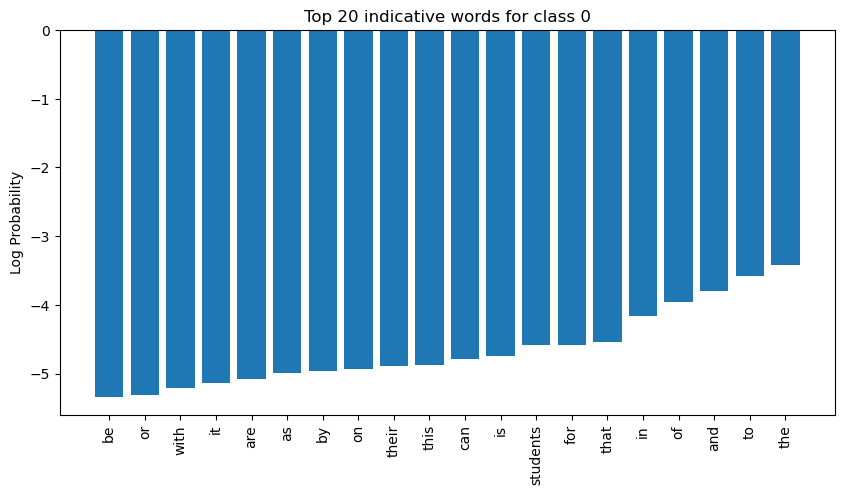

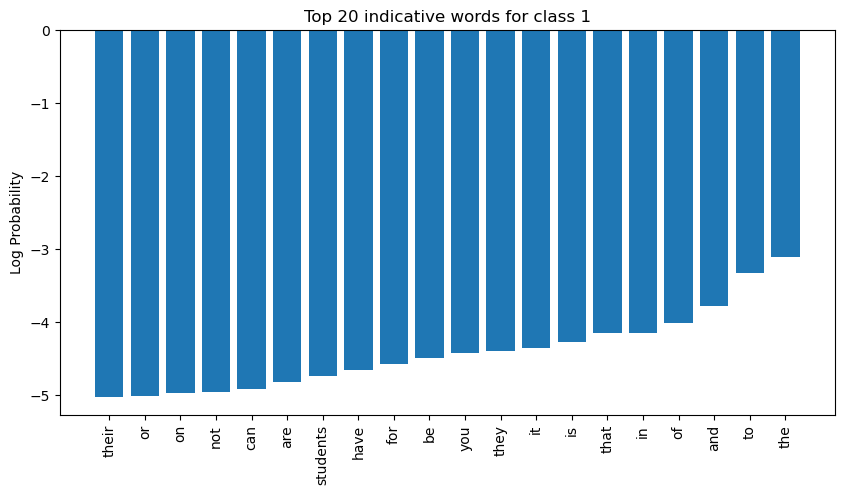

In [27]:
plot_feature_log_prob(bow_model)

In [28]:
#test
sample_df = pd.read_csv('Generated_Data.csv')
test_texts = sample_df['Text']
test_labels = sample_df['LABEL']

In [31]:
pred_labels = bow_model.predict(test_texts)
pred_prob = bow_model.predict_proba(test_texts)

In [35]:
#avg confidence
np.sum(pred_labels[pred_labels == test_labels])

30

In [61]:
pred_prob.shape

(60, 2)

In [77]:
#human
threshold = 0.8
count_high = 0
total_count = 0
for pred in pred_prob:
    #print(np.argmax(pred))
    if np.argmax(pred) == 1:
        total_count += 1
        #print(pred.max())
        if pred.max() > threshold:
            count_high += 1

print(count_high / total_count)

1.0


In [92]:
#ai

threshold = 0.2
count_high = 0
total_count = 0
for pred in pred_prob:
    #print(np.argmax(pred))
    if np.argmin(pred) == 0:
        total_count += 1
        #print(pred.max())
        if pred.min() < threshold:
            count_high += 1

print(count_high / total_count)

1.0


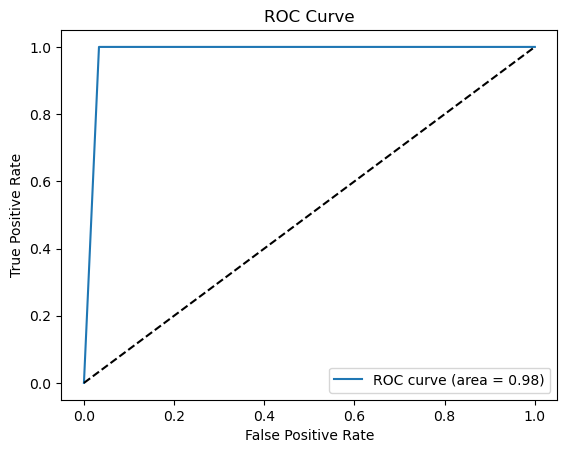

In [100]:
from sklearn.metrics import roc_curve, auc

human_label_prob = pred_prob[:, 1]
fpr, tpr, thresholds = roc_curve(test_labels, human_label_prob)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [8]:
representation_methods = {'TF-IDF': TfidfVectorizer()}
tfidf_model = train_and_evaluate(texts, labels, representation_methods)

TF-IDF Accuracy: 0.9333


In [9]:
tfidf_model.named_steps

{'tfidfvectorizer': TfidfVectorizer(), 'multinomialnb': MultinomialNB()}

In [10]:
def plot_feature_log_prob(pipeline, top_features=20):
    vectorizer = pipeline.named_steps['tfidfvectorizer']  
    classifier = pipeline.named_steps['multinomialnb']
    feature_names = vectorizer.get_feature_names_out()
    
    for i, class_label in enumerate(classifier.classes_):
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-top_features:]
        plt.figure(figsize=(10, 5))
        plt.title(f"Top {top_features} indicative words for class {class_label}")
        plt.bar(feature_names[top_indices], classifier.feature_log_prob_[i][top_indices])
        plt.xticks(rotation=90)
        plt.ylabel('Log Probability')
        plt.show()

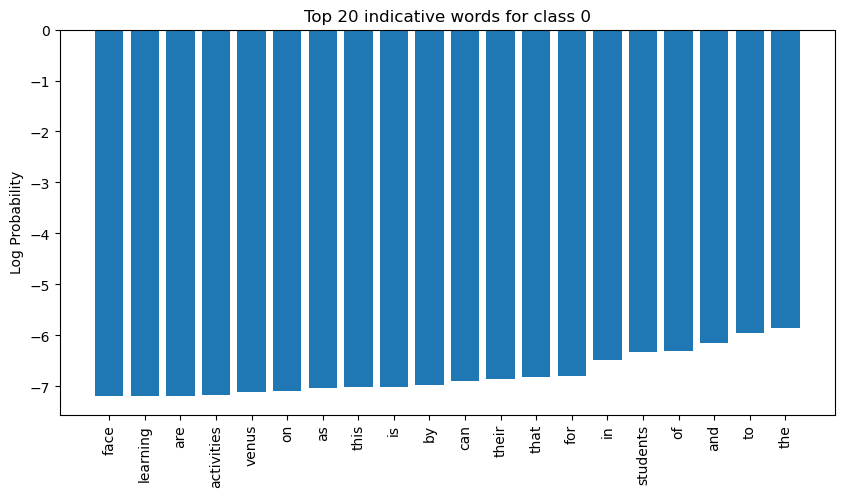

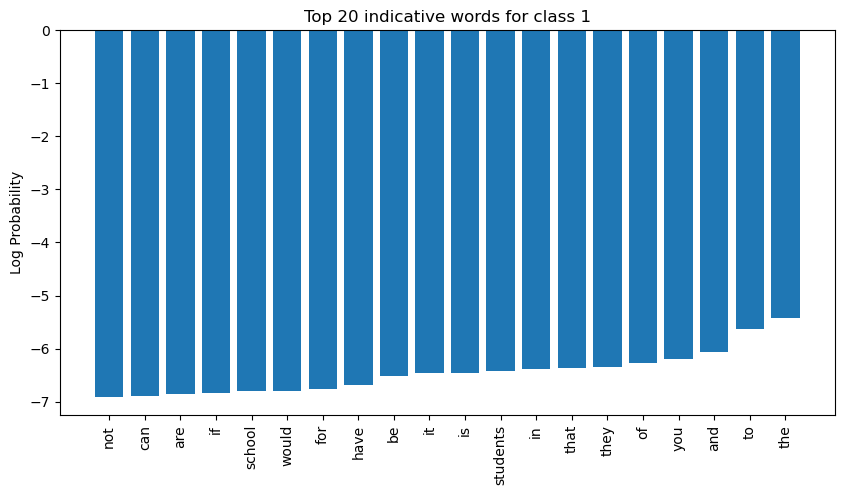

In [11]:
plot_feature_log_prob(tfidf_model)

In [12]:
representation_methods = {'N-grams': CountVectorizer(ngram_range=(1, 2))}
ngram_model = train_and_evaluate(texts, labels, representation_methods)

N-grams Accuracy: 0.9833


In [13]:
ngram_model.named_steps

{'countvectorizer': CountVectorizer(ngram_range=(1, 2)),
 'multinomialnb': MultinomialNB()}

In [14]:
def plot_feature_log_prob(pipeline, top_features=20):
    vectorizer = pipeline.named_steps['countvectorizer']  
    classifier = pipeline.named_steps['multinomialnb']
    feature_names = vectorizer.get_feature_names_out()
    
    for i, class_label in enumerate(classifier.classes_):
        top_indices = np.argsort(classifier.feature_log_prob_[i])[-top_features:]
        plt.figure(figsize=(10, 5))
        plt.title(f"Top {top_features} indicative words for class {class_label}")
        plt.bar(feature_names[top_indices], classifier.feature_log_prob_[i][top_indices])
        plt.xticks(rotation=90)
        plt.ylabel('Log Probability')
        plt.show()

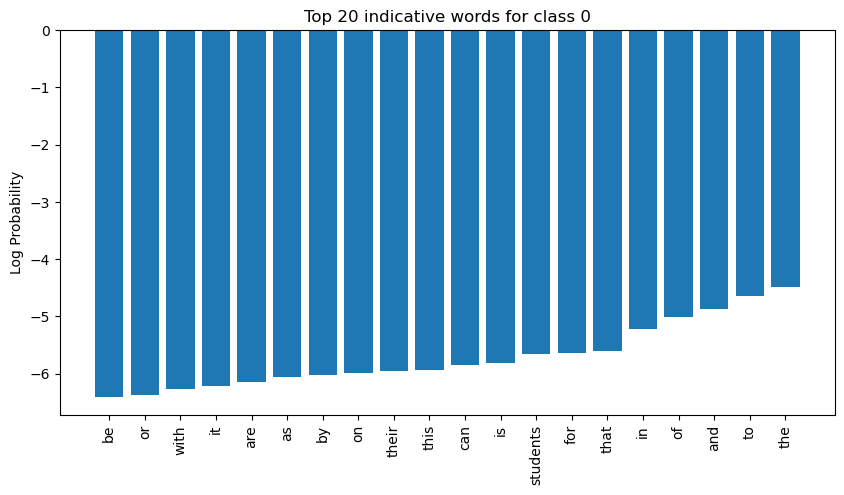

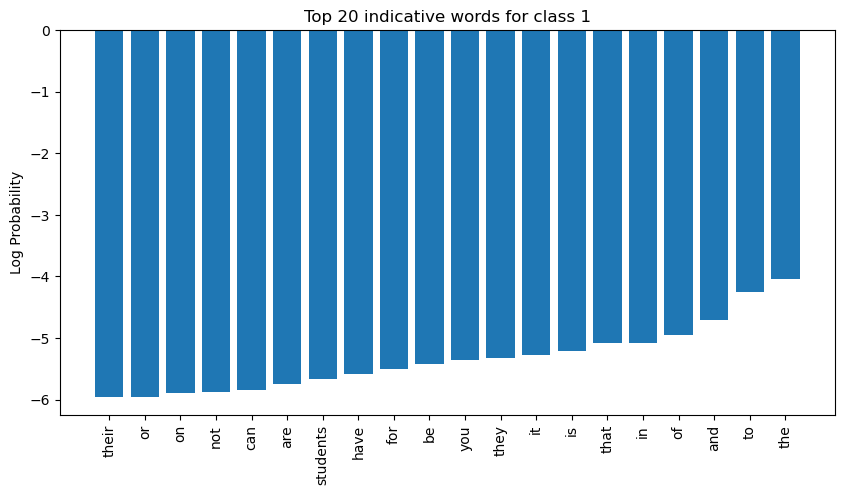

In [15]:
plot_feature_log_prob(ngram_model)

In [16]:
from sklearn.manifold import TSNE
import seaborn as sns


def plot_tsne(pipeline, X, y):
    # Transform features using the vectorizer component of the pipeline
    transformed_features = pipeline.named_steps['countvectorizer'].transform(X)  # Adjust based on actual step name
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(transformed_features.toarray())  # Convert to array if sparse
    
    sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=y, palette=sns.color_palette("hsv", len(set(y))))
    plt.title('t-SNE visualization of feature space')
    plt.show()

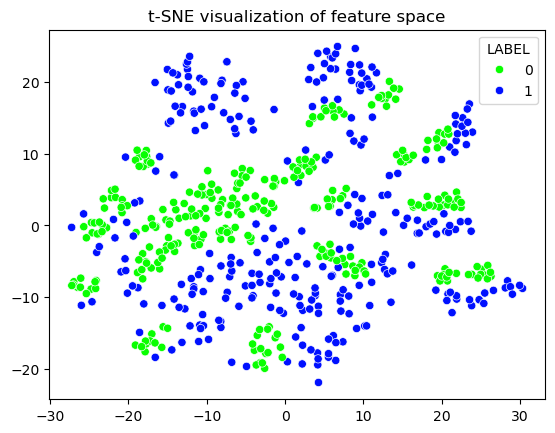

In [18]:
plot_tsne(bow_model, texts, labels)

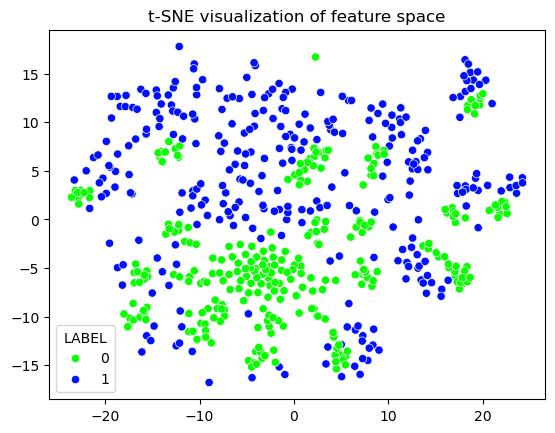

In [20]:
plot_tsne(ngram_model, texts, labels)